In [11]:
from data.dataset import GWF_HP_Dataset
from data.dataloader import DataLoader
from data.transforms import NormalizeTransform, ComposeTransform, CutOffEdgesTransform
from visualization.visualize_data import plot_datapoint
import os
import numpy as np

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
from tqdm.auto import tqdm

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# TODO not necessary to cut of edges - exponential behaviour at edges ?! fix it otherwise!
#transforms = ComposeTransform([NormalizeTransform(), CutOffEdgesTransform()])
transform_normalize = NormalizeTransform()
dataset = GWF_HP_Dataset(dataset_name ="dataset_HDF5_testtest", transform = transform_normalize)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Dataloader size: {len(dataloader)}")

# TODO: directly include  split into the dataset class (ex6 class ImageFolderDataset)
#dataloader for each mode (train, val, test) (ex 6)

Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/dataset_HDF5_testtest
Dataset size: 5
Dataloader size: 3


# test visualization of data

In [20]:
dataset[0]['x'][0,:,:,:].shape

(20, 150, 16)

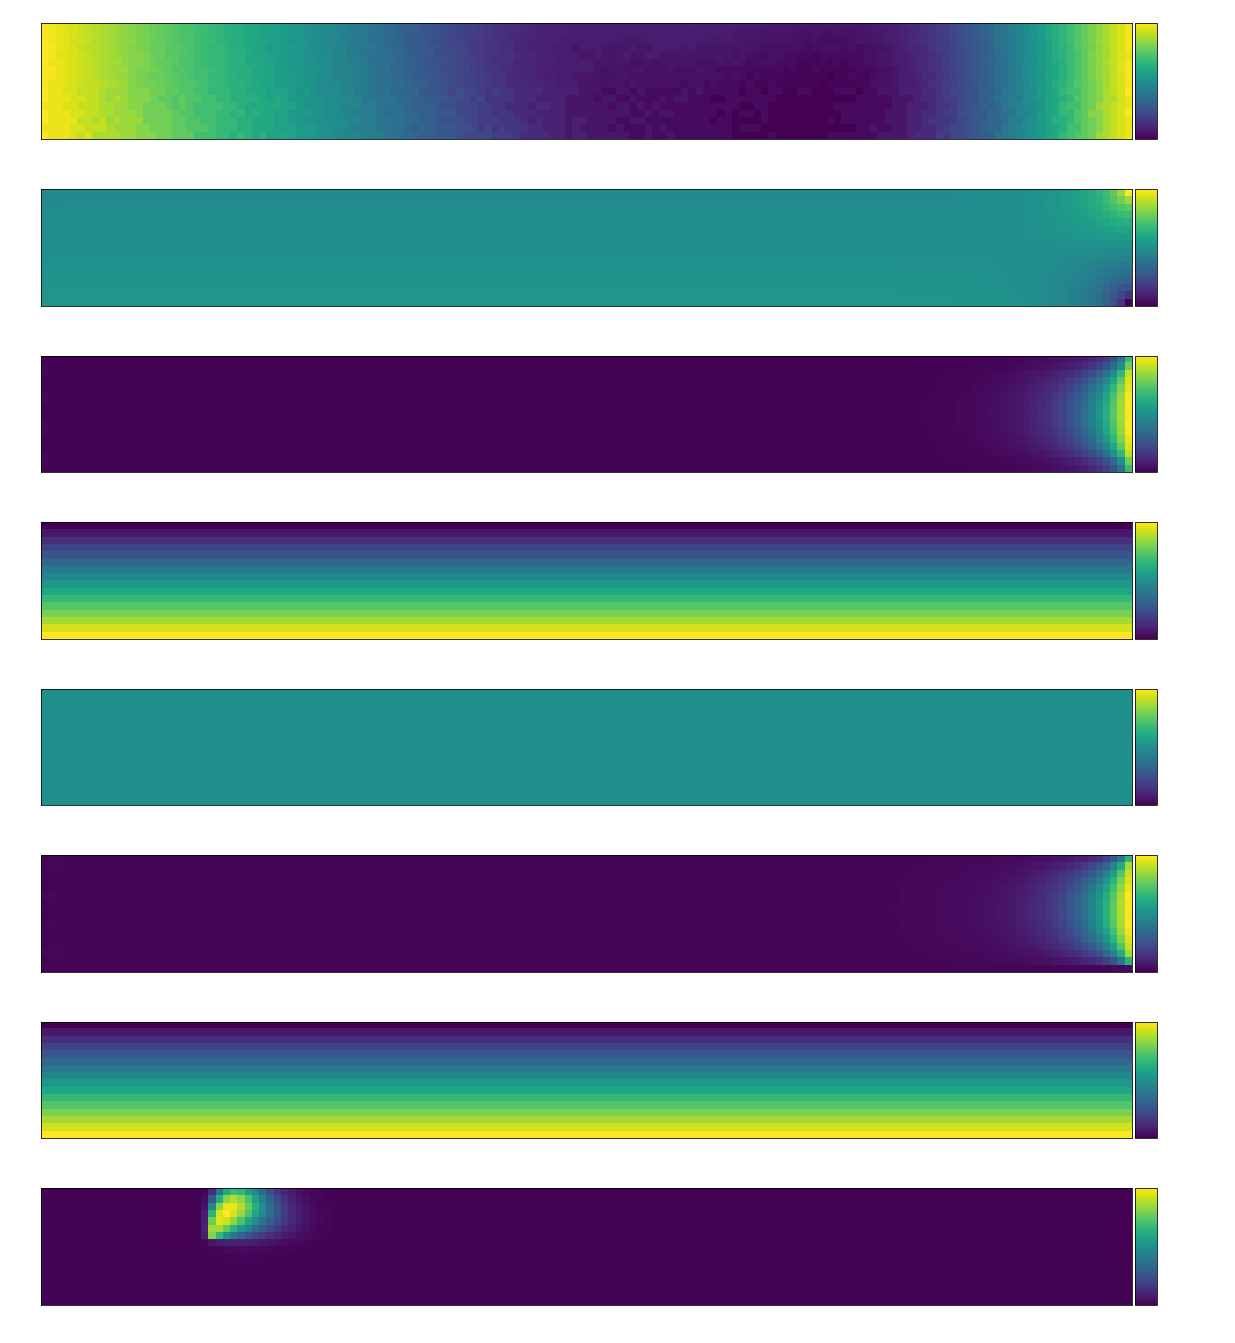

In [27]:
plot_datapoint(dataset, run_id=1, view="side_hp")

In [ ]:
# TODO:  data augmentation

#  continue FCNN preprocessing here

In [3]:
def f(**kwargs):
    print(kwargs)

def summe(*args):
    temp = 0
    for arg in args:
        temp += arg

    return temp

def weird(*args):
    text = args[0]
    number = args[1]
    print(f"{text} {number}")
    
f(a = "hello", b = "world")
weird("hello", 3)
summe(2,3,4,4)

def potenz(*args, potenz=1, **kwargs):
    print(*args)
    return np.sum(args)**potenz

potenz(2,3, c=4, d=5, potenz=2)

{'a': 'hello', 'b': 'world'}
hello 3
2 3


NameError: name 'np' is not defined

In [21]:
import matplotlib.pyplot as plt

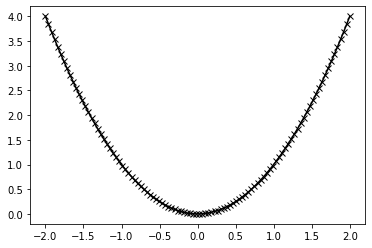

In [25]:
def plot_p(xmin, xmax, **kwargs):
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, x**2, **kwargs)
    plt.show()

plot_p(-2, 2, color="black", marker="x")
